=== IEEE 13-Node Test Feeder (Dados Oficiais) ===
Barras: [650, 632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
Número de barras: 13
Número de linhas: 12
Barra slack: 650
Barras PQ: [632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
Base de potência: 5.0 MVA
Base de tensão: 4.16 kV (LL), 2.402 kV (LN)
Base de impedância: 3.461 ohms

Cargas do Sistema (kW + j kVAr):
Barra 632: 33.3 kW + j19.3 kVAr
Barra 634: 133.3 kW + j96.7 kVAr
Barra 645: 56.7 kW + j41.7 kVAr
Barra 646: 76.7 kW + j44.0 kVAr
Barra 671: 418.3 kW + j239.3 kVAr
Barra 611: 56.7 kW + j26.7 kVAr
Barra 652: 42.7 kW + j28.7 kVAr
Barra 692: 56.7 kW + j50.3 kVAr
Barra 675: 281.0 kW + j154.0 kVAr

Capacitores do Sistema:
Barra 675: 200.0 kVAr
Barra 611: 33.3 kVAr

Resumo do Sistema:
Carga total: 1155.3 kW + j700.7 kVAr
Capacitores: 233.3 kVAr
Carga líquida: 1155.3 kW + j467.3 kVAr

Valores de referência do documento IEEE:
Carga total sistema: 3466.1 kW + j2101.6 kVAr
Input da subestação: 3577.2 kW + j1724.8 

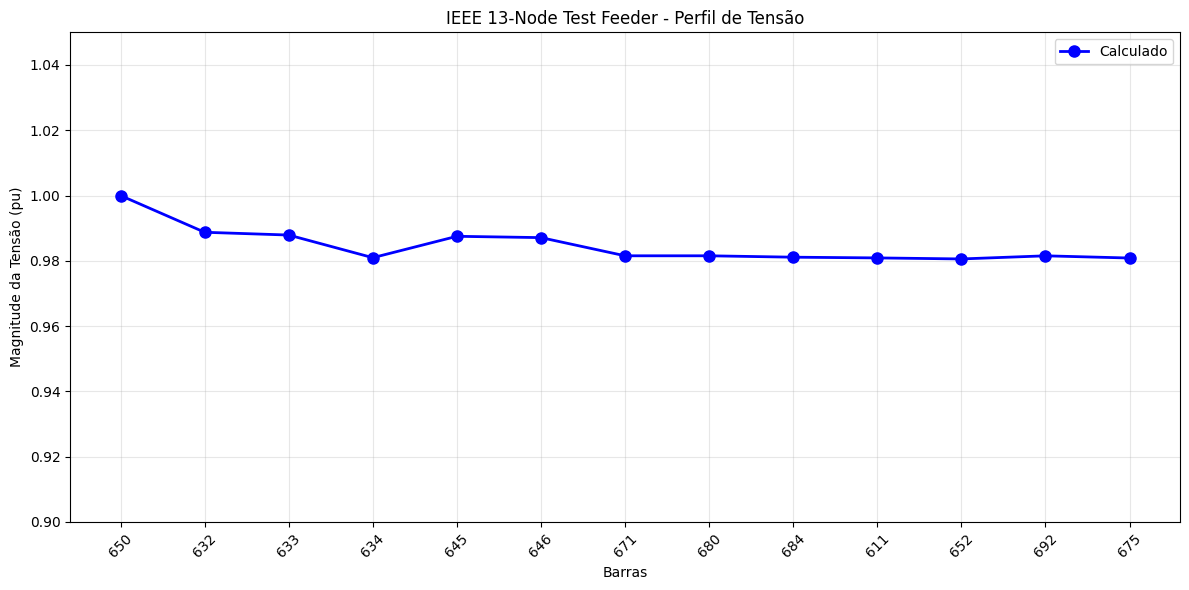

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from src.zmatrix_models import MetodoMatrizZdetailed
# Add this function to your code
def print_ybus_formatted(Y_bus, barras):
    """Imprime a matriz Y_bus de forma formatada com nomes das barras"""
    n = len(barras)
    
    print("\n=== Matriz Y_bus Formatada ===")
    print(f"{'Barra':<6}", end='')
    for barra in barras:
        print(f"{barra:>15}", end='')
    print()
    
    for i in range(n):
        print(f"{barras[i]:<6}", end='')
        for j in range(n):
            real = Y_bus[i, j].real
            imag = Y_bus[i, j].imag
            if abs(Y_bus[i, j]) < 1e-10:  # Valores muito pequenos = zero
                print(f"{'0.0000':>15}", end='')
            else:
                print(f"{real:>7.4f}{'+' if imag >= 0 else ''}{imag:.4f}j", end='')
        print()

def ieee_13_node_test_feeder():
    """
    Configuração do sistema IEEE 13-node test feeder
    Baseado nos dados oficiais do IEEE Distribution Test Feeders
    """
    
    # Definir as barras do sistema conforme documento IEEE
    barras = [650, 632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
    
    # Tipos de barras
    # Barra 650 é a barra slack (subestação)
    # Todas as outras são barras PQ (cargas)
    barras_tipo = {
        650: 0,  # Slack bus (subestação)
        632: 2,  # PQ (node intermediário)
        633: 2,  # PQ
        634: 2,  # PQ
        645: 2,  # PQ
        646: 2,  # PQ
        671: 2,  # PQ
        680: 2,  # PQ
        684: 2,  # PQ
        611: 2,  # PQ
        652: 2,  # PQ
        692: 2,  # PQ (switch node)
        675: 2   # PQ
    }
    # barras_tipo = {
    #     611: 2,  # PQ
    #     632: 2,  # PQ (node intermediário)
    #     633: 2,  # PQ
    #     634: 2,  # PQ
    #     645: 2,  # PQ
    #     646: 2,  # PQ
    #     652: 2,  # PQ
    #     671: 2,  # PQ
    #     675: 2,   # PQ
    #     680: 2,  # PQ
    #     684: 2,  # PQ
    #     692: 2,  # PQ (switch node)   
    #     650: 0,  # Slack bus (subestação)

    # }
    
    # Tensões iniciais baseadas nos resultados do documento
    # Tensão base: 4.16 kV (linha-linha), 2.4019 kV (linha-neutro)
    v_base_ll = 4.16  # kV
    v_base_ln = v_base_ll / np.sqrt(3)  # kV linha-neutro
    
    # Tensões iniciais 
    v_inicial = {
        650: 1.0 + 0.0j,  # Tensão da subestação (2% acima do nominal)
        632: 1.0 + 0.0j,
        633: 1.0 + 0.0j,
        634: 1.0 + 0.0j,
        645: 1.0 + 0.0j,
        646: 1.0 + 0.0j,
        671: 1.0 + 0.0j,
        680: 1.0 + 0.0j,
        684: 1.0 + 0.0j,
        611: 1.0 + 0.0j,
        652: 1.0 + 0.0j,
        692: 1.0 + 0.0j,
        675: 1.0 + 0.0j
    }
    
    # Potências das cargas baseadas nos dados do documento
    # Base de potência: 5 MVA (assumida para conversão pu)
    s_base = 5.0  # MVA
    
    # Cargas spot loads do documento convertidas para pu (total das 3 fases)
    # potencias = {
    #     650: 0.0 + 0.0j,                           # Subestação (barra slack)
    #     632: 0.0 + 0.0j,                           # Sem carga spot (apenas distributed load)
    #     633: 0.0 + 0.0j,                           # Sem carga spot
    #     634: -(160+120+120)/1000/s_base - 1j*(110+90+90)/1000/s_base,  # 400 kW + 290 kVAr
    #     645: -170/1000/s_base - 1j*125/1000/s_base,    # 170 kW + 125 kVAr (phase B only)
    #     646: -230/1000/s_base - 1j*132/1000/s_base,    # 230 kW + 132 kVAr (phase B only, D-Z)
    #     671: -(385+385+385)/1000/s_base - 1j*(220+220+220)/1000/s_base,  # 1155 kW + 660 kVAr (D-PQ)
    #     680: 0.0 + 0.0j,                           # Sem carga
    #     684: 0.0 + 0.0j,                           # Sem carga
    #     611: -170/1000/s_base - 1j*80/1000/s_base,     # 170 kW + 80 kVAr (phase C, Y-I)
    #     652: -128/1000/s_base - 1j*86/1000/s_base,     # 128 kW + 86 kVAr (phase A, Y-Z)
    #     692: -170/1000/s_base - 1j*151/1000/s_base,    # 170 kW + 151 kVAr (phase C, D-I)
    #     675: -(485+68+290)/1000/s_base - 1j*(190+60+212)/1000/s_base  # 843 kW + 462 kVAr (Y-PQ)
    # }

    potencias = {
        650: 0.0 + 0.0j,                           # Subestação (barra slack)
        632: 0.0 + 0.0j,                           # Sem carga spot (apenas distributed load)
        633: 0.0 + 0.0j,                           # Sem carga spot
        634: (-(160+120+120)/1000/s_base - 1j*(110+90+90)/1000/s_base)/3,  # 400 kW + 290 kVAr
        645: (-170/1000/s_base - 1j*125/1000/s_base)/3,    # 170 kW + 125 kVAr (phase B only)
        646: (-230/1000/s_base - 1j*132/1000/s_base)/3,    # 230 kW + 132 kVAr (phase B only, D-Z)
        671: (-(385+385+385)/1000/s_base - 1j*(220+220+220)/1000/s_base)/3,  # 1155 kW + 660 kVAr (D-PQ)
        680: 0.0 + 0.0j,                           # Sem carga
        684: 0.0 + 0.0j,                           # Sem carga
        611: (-170/1000/s_base - 1j*80/1000/s_base)/3,     # 170 kW + 80 kVAr (phase C, Y-I)
        652: (-128/1000/s_base - 1j*86/1000/s_base)/3,     # 128 kW + 86 kVAr (phase A, Y-Z)
        692: (-170/1000/s_base - 1j*151/1000/s_base)/3,    # 170 kW + 151 kVAr (phase C, D-I)
        675: (-(485+68+290)/1000/s_base - 1j*(190+60+212)/1000/s_base)/3  # 843 kW + 462 kVAr (Y-PQ)
    }
    
    # Distributed load na linha 632-671
    distributed_load = {
        'P': ((17 + 66 + 117)/1000/s_base)/3,  # 200 kW total
        'Q': ((10 + 38 + 68)/1000/s_base)/3    # 116 kVAr total
    }
    
    # Adicionar distributed load dividida entre as barras
    potencias[632] = potencias[632] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    potencias[671] = potencias[671] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    
    # Conexões do sistema baseadas no Line Segment Data do documento
    linhas = [
        (650, 632),  # 2000 ft, Config 601
        (632, 633),  # 500 ft, Config 602
        (633, 634),  # Transformador XFM-1
        (632, 645),  # 500 ft, Config 603
        (645, 646),  # 300 ft, Config 603
        (632, 671),  # 2000 ft, Config 601
        (671, 684),  # 300 ft, Config 604
        (684, 611),  # 300 ft, Config 605
        (684, 652),  # 800 ft, Config 607
        (671, 680),  # 1000 ft, Config 601
        (671, 692),  # Switch (impedância zero)
        (692, 675)   # 500 ft, Config 606
    ]
    
    # Impedâncias das linhas baseadas nas configurações do documento
    # Convertidas de ohms/mile para pu usando bases de 100 MVA e 4.16 kV
    z_base = (v_base_ll**2) / s_base  # ohms
    
    # Configurações de linha do documento (valores médios das 3 fases em ohms/mile)
    # config_impedances = {
    #     601: (0.3418 + 1j*1.0335),    # Config 601 - overhead 3ph
    #     602: (0.7479 + 1j*1.1970),    # Config 602 - overhead 3ph  
    #     603: (1.3266 + 1j*1.3520),    # Config 603 - overhead 2ph
    #     604: (1.3266 + 1j*1.3520),    # Config 604 - overhead 2ph
    #     605: (1.3292 + 1j*1.3475),    # Config 605 - overhead 1ph
    #     606: (0.7917 + 1j*0.4390),    # Config 606 - underground 3ph
    #     607: (1.3425 + 1j*0.5124)     # Config 607 - underground 1ph
    # }
    
    # Impedâncias das linhas em pu
    # impedancias_linhas = {
    #     (650, 632): config_impedances[601] * (2000/5280) / z_base,  # 2000 ft
    #     (632, 633): config_impedances[602] * (500/5280) / z_base,   # 500 ft
    #     (633, 634): 0.011 + 1j*0.02,  # Transformador 500 kVA (estimado)
    #     (632, 645): config_impedances[603] * (500/5280) / z_base,   # 500 ft
    #     (645, 646): config_impedances[603] * (300/5280) / z_base,   # 300 ft
    #     (632, 671): config_impedances[601] * (2000/5280) / z_base,  # 2000 ft
    #     (671, 684): config_impedances[604] * (300/5280) / z_base,   # 300 ft
    #     (684, 611): config_impedances[605] * (300/5280) / z_base,   # 300 ft
    #     (684, 652): config_impedances[607] * (800/5280) / z_base,   # 800 ft
    #     (671, 680): config_impedances[601] * (1000/5280) / z_base,  # 1000 ft
    #     (671, 692): 0.0001 + 1j*0.0001,  # Switch (impedância muito baixa)
    #     (692, 675): config_impedances[606] * (500/5280) / z_base    # 500 ft
    # }

    # impedancias_linhas = {
    #     (650, 632): 0.0204 + 0.0653*1j,
    #     (632, 633): 0.0162 + 0.0208*1j,
    #     (633, 634): 0.0001 + 1j*0.0001,  
    #     (632, 645): 0.0223 + 0.0205*1j,
    #     (645, 646): 0.0134 + 0.0123*1j,
    #     (632, 671): 0.0204 + 0.0653*1j,
    #     (671, 684): 0.0134 + 0.0123*1j,
    #     (684, 611): 0.0073 + 0.0074*1j,
    #     (684, 652): 0.0196 + 0.0075*1j,
    #     (671, 680): 0.0102 + 0.0327*1j,
    #     (671, 692): 0.0001 + 1j*0.0001, 
    #     (692, 675): 0.0133 + 0.0114*1j,
    # }
    
    impedancias_linhas = {
        (632, 645): 0.030643435 + 0.024429931*1j,
        (632, 633): 0.016199068 + 0.020800144*1j,
        (645, 646): 0.018386061 + 0.014657959*1j,
        (650, 632): 0.020352348 + 0.065310645*1j,
        (684, 652): 0.020352348 + 0.065310645*1j,
        (632, 671): 0.020352348 + 0.065310645*1j,
        (671, 684): 0.018386061 + 0.014657959*1j,
        (671, 680): 0.018386061 + 0.014657959*1j,
        (684, 611): 0.021820315 + 0.02212073*1j,
        (692, 675): 0.013335366 + 0.011358135*1j,
        (633, 634): 0.11 + 1j*0.2, 
        (671, 692): 0.0001 + 1j*0.0001,
    }
    
    # Construir matriz de admitância Y_bus
    n_barras = len(barras)
    Y_bus = np.zeros((n_barras, n_barras), dtype=complex)
    
    # Mapear barras para índices
    idx_map = {barra: i for i, barra in enumerate(barras)}
    
    # Capacitores baseados nos dados do documento
    # Convertidos para pu na base de 5 MVA
    capacitores = {
        675: (1j * (200 + 200 + 200) / 1000 / s_base)/3,  # 600 kVAr total
        611: (1j * 100 / 1000 / s_base)/3                  # 100 kVAr
    }
    
    # Preencher matriz Y_bus
    for linha in linhas:
        barra_i, barra_j = linha
        i = idx_map[barra_i]
        j = idx_map[barra_j]
        
        # Admitância série da linha
        z_linha = impedancias_linhas[linha]
        y_linha = 1.0 / z_linha
        
        # Elementos off-diagonal (negativos)
        Y_bus[i, j] = -y_linha
        Y_bus[j, i] = -y_linha
        
        # Elementos diagonais (soma das admitâncias conectadas)
        Y_bus[i, i] += y_linha
        Y_bus[j, j] += y_linha
    
    # Adicionar capacitores (admitâncias shunt)
    for barra, y_cap in capacitores.items():
        i = idx_map[barra]
        Y_bus[i, i] += y_cap
    
    print("=== IEEE 13-Node Test Feeder (Dados Oficiais) ===")
    print(f"Barras: {barras}")
    print(f"Número de barras: {len(barras)}")
    print(f"Número de linhas: {len(linhas)}")
    print(f"Barra slack: {[b for b, t in barras_tipo.items() if t == 0][0]}")
    print(f"Barras PQ: {[b for b, t in barras_tipo.items() if t == 2]}")
    print(f"Base de potência: {s_base} MVA")
    print(f"Base de tensão: {v_base_ll} kV (LL), {v_base_ln:.3f} kV (LN)")
    print(f"Base de impedância: {z_base:.3f} ohms")
    
    print("\nCargas do Sistema (kW + j kVAr):")
    for barra in barras:
        if abs(potencias[barra]) > 0.001:
            P_kW = -potencias[barra].real * s_base * 1000
            Q_kVAr = -potencias[barra].imag * s_base * 1000
            print(f"Barra {barra}: {P_kW:.1f} kW + j{Q_kVAr:.1f} kVAr")
    
    print("\nCapacitores do Sistema:")
    for barra, y_cap in capacitores.items():
        Q_kVAr = y_cap.imag * s_base * 1000
        print(f"Barra {barra}: {Q_kVAr:.1f} kVAr")
    
    # Calcular carga total
    P_total = -sum(p.real for p in potencias.values()) * s_base * 1000
    Q_total = -sum(p.imag for p in potencias.values()) * s_base * 1000
    Q_cap_total = sum(y.imag for y in capacitores.values()) * s_base * 1000
    
    print(f"\nResumo do Sistema:")
    print(f"Carga total: {P_total:.1f} kW + j{Q_total:.1f} kVAr")
    print(f"Capacitores: {Q_cap_total:.1f} kVAr")
    print(f"Carga líquida: {P_total:.1f} kW + j{Q_total-Q_cap_total:.1f} kVAr")
    
    # Valores de referência do documento para comparação
    print(f"\nValores de referência do documento IEEE:")
    print(f"Carga total sistema: 3466.1 kW + j2101.6 kVAr")
    print(f"Input da subestação: 3577.2 kW + j1724.8 kVAr")
    print(f"Perdas do sistema: 111.1 kW + j324.7 kVAr")
    
    print("\nMatriz de Admitância Y_bus (elementos principais):")
    print("Diagonal principal (admitâncias próprias):")
    for i, barra in enumerate(barras[:5]):  # Mostrar apenas as primeiras 5
        real = Y_bus[i, i].real
        imag = Y_bus[i, i].imag
        print(f"Y[{barra},{barra}] = {real:.6f}{'+' if imag >= 0 else ''}{imag:.6f}j")
    
    print_ybus_formatted(Y_bus, barras)
    # Modelos de carga baseados nos tipos do documento
    # Y-PQ: Potência constante
    # Y-Z: Impedância constante  
    # Y-I: Corrente constante
    # D-PQ, D-Z, D-I: Delta connection
    load_models = {
        650: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Subestação
        632: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        633: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        634: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Y-PQ (potência constante)
        645: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Y-PQ (potência constante)
        646: {'P': 0.0, 'I': 0.0, 'Z': 1.0},  # D-Z (impedância constante)
        671: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # D-PQ (potência constante)
        680: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        684: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        611: {'P': 0.0, 'I': 1.0, 'Z': 0.0},  # Y-I (corrente constante)
        652: {'P': 0.0, 'I': 0.0, 'Z': 1.0},  # Y-Z (impedância constante)
        692: {'P': 0.0, 'I': 1.0, 'Z': 0.0},  # D-I (corrente constante)
        675: {'P': 1.0, 'I': 0.0, 'Z': 0.0}   # Y-PQ (potência constante)
    }
    
    # Tolerância
    tolerancia = 0.0001
    
    print(f"\n=== Executando Análise de Fluxo de Potência ===")
    print(f"Tolerância: {tolerancia}")
    
    # Criar instância do solver
    solver = MetodoMatrizZdetailed(Y_bus, barras, linhas, barras_tipo, potencias, 
                                 v_inicial, load_models=load_models, tol=tolerancia)
    
    # Resolver usando método da matriz Z com substituição em bloco
    print("\n--- Método de Substituição em Bloco ---")
    v_bloco, v_history_bloco, iteracoes_bloco = solver.substituicao_em_bloco()
    fluxos_bloco = solver.calcular_fluxos(v_bloco)
    
    # Exibir resultados
    solver.exibir_resultados(v_bloco, fluxos_bloco, "Substituição em Bloco", iteracoes_bloco)
    
    # Comparar com valores de referência do documento
    print(f"\n=== Comparação com Valores de Referência IEEE ===")
    print(f"{'Barra':<6} {'V_calc(pu)':<12} {'V_ref(pu)':<12} {'Erro(%)':<10}")
    print("-" * 50)
    
    # Valores de referência do perfil de tensão do documento
    v_ref = {
        650: 1.000,
        632: 1.021,
        633: 1.018,  
        634: 0.994,
        645: 1.033,
        646: 1.031,
        671: 0.990,
        680: 0.990,
        684: 0.988,
        611: 0.974,
        652: 0.983,
        692: 0.990,
        675: 0.983
    }
    
    for i, barra in enumerate(barras):
        v_calc = abs(v_bloco[i])
        v_reference = v_ref[barra]
        erro = abs(v_calc - v_reference) / v_reference * 100
        print(f"{barra:<6} {v_calc:<12.4f} {v_reference:<12.4f} {erro:<10.2f}")
    
    # Plotar perfil de tensão
    plt.figure(figsize=(12, 6))
    v_magnitudes = [abs(v) for v in v_bloco]
    v_ref_values = [v_ref[barra] for barra in barras]
    
    x = range(len(barras))
    plt.plot(x, v_magnitudes, 'bo-', label='Calculado', linewidth=2, markersize=8)
    #plt.plot(x, v_ref_values, 'rs--', label='Referência IEEE', linewidth=2, markersize=8)
    
    plt.xlabel('Barras')
    plt.ylabel('Magnitude da Tensão (pu)')
    plt.title('IEEE 13-Node Test Feeder - Perfil de Tensão')
    plt.xticks(x, [str(b) for b in barras], rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0.90, 1.05)
    plt.tight_layout()
    plt.show()
    
    return solver, v_bloco, fluxos_bloco

# Executar o sistema IEEE 13-node
if __name__ == "__main__":
    solver, tensoes, fluxos = ieee_13_node_test_feeder()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from src.pv_curve import PVCurveAnalysis

def setup_ieee_13_system():
    """Setup the IEEE 13-node balanced system for PV curve analysis"""
    
    # Define system barras
    barras = [650, 632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
    
    # Tipos de barras
    barras_tipo = {
        650: 0,  # Slack bus (subestação)
        632: 2,  # PQ
        633: 2,  # PQ
        634: 2,  # PQ
        645: 2,  # PQ
        646: 2,  # PQ
        671: 2,  # PQ
        680: 2,  # PQ
        684: 2,  # PQ
        611: 2,  # PQ
        652: 2,  # PQ
        692: 2,  # PQ
        675: 2   # PQ
    }
    
    # Tensões iniciais
    v_inicial = {
        650: 1.0 + 0.0j,  # Slack bus
        632: 1.0 + 0.0j,
        633: 1.0 + 0.0j,
        634: 1.0 + 0.0j,
        645: 1.0 + 0.0j,
        646: 1.0 + 0.0j,
        671: 1.0 + 0.0j,
        680: 1.0 + 0.0j,
        684: 1.0 + 0.0j,
        611: 1.0 + 0.0j,
        652: 1.0 + 0.0j,
        692: 1.0 + 0.0j,
        675: 1.0 + 0.0j
    }
    
    # Base de potência para conversão pu
    s_base = 5.0  # MVA
    
    # Potências das cargas (balanced equivalent - divididas por 3)
    potencias = {
        650: 0.0 + 0.0j,                           # Slack bus
        632: 0.0 + 0.0j,                           # No spot load
        633: 0.0 + 0.0j,                           # No spot load
        634: (-(160+120+120)/1000/s_base - 1j*(110+90+90)/1000/s_base)/3,
        645: (-170/1000/s_base - 1j*125/1000/s_base)/3,
        646: (-230/1000/s_base - 1j*132/1000/s_base)/3,
        671: (-(385+385+385)/1000/s_base - 1j*(220+220+220)/1000/s_base)/3,
        680: 0.0 + 0.0j,                           # No load
        684: 0.0 + 0.0j,                           # No load
        611: (-170/1000/s_base - 1j*80/1000/s_base)/3,
        652: (-128/1000/s_base - 1j*86/1000/s_base)/3,
        692: (-170/1000/s_base - 1j*151/1000/s_base)/3,
        675: (-(485+68+290)/1000/s_base - 1j*(190+60+212)/1000/s_base)/3
    }
    
    # Distributed load na linha 632-671
    distributed_load = {
        'P': ((17 + 66 + 117)/1000/s_base)/3,
        'Q': ((10 + 38 + 68)/1000/s_base)/3
    }
    
    # Adicionar distributed load
    potencias[632] = potencias[632] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    potencias[671] = potencias[671] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    
    # Conexões do sistema
    linhas = [
        (650, 632), (632, 633), (633, 634), (632, 645), (645, 646),
        (632, 671), (671, 684), (684, 611), (684, 652), (671, 680),
        (671, 692), (692, 675)
    ]
    
    # Impedâncias das linhas
    impedancias_linhas = {
        (650, 632): 0.0204 + 0.0653*1j,
        (632, 633): 0.0162 + 0.0208*1j,
        (633, 634): 0.0001 + 1j*0.0001,
        (632, 645): 0.0223 + 0.0205*1j,
        (645, 646): 0.0134 + 0.0123*1j,
        (632, 671): 0.0204 + 0.0653*1j,
        (671, 684): 0.0134 + 0.0123*1j,
        (684, 611): 0.0073 + 0.0074*1j,
        (684, 652): 0.0196 + 0.0075*1j,
        (671, 680): 0.0102 + 0.0327*1j,
        (671, 692): 0.0001 + 1j*0.0001,
        (692, 675): 0.0133 + 0.0114*1j,
    }
    
    # Construir matriz Y_bus
    n_barras = len(barras)
    Y_bus = np.zeros((n_barras, n_barras), dtype=complex)
    
    # Mapear barras para índices
    idx_map = {barra: i for i, barra in enumerate(barras)}
    
    # Capacitores
    capacitores = {
        675: (1j * (200 + 200 + 200) / 1000 / s_base)/3,
        611: (1j * 100 / 1000 / s_base)/3
    }
    
    # Preencher matriz Y_bus
    for linha in linhas:
        barra_i, barra_j = linha
        i = idx_map[barra_i]
        j = idx_map[barra_j]
        
        z_linha = impedancias_linhas[linha]
        y_linha = 1.0 / z_linha
        
        # Elementos off-diagonal
        Y_bus[i, j] = -y_linha
        Y_bus[j, i] = -y_linha
        
        # Elementos diagonais
        Y_bus[i, i] += y_linha
        Y_bus[j, j] += y_linha
    
    # Adicionar capacitores
    for barra, y_cap in capacitores.items():
        i = idx_map[barra]
        Y_bus[i, i] += y_cap
    
    return {
        'barras': barras,
        'barras_tipo': barras_tipo,
        'potencias': potencias,
        'v_inicial': v_inicial,
        'linhas': linhas,
        'Y_bus': Y_bus,
        's_base': s_base,
        'idx_map': idx_map
    }


def plot_pv_curves_13node(results_dict, scenario_name, system):
    """Plot P-V curves for IEEE 13-node system"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    load_multipliers = results_dict['load_multipliers']
    voltages = results_dict['voltages']
    
    # Find last converged point
    last_converged_idx = results_dict['converged'].index(False) - 1 if False in results_dict['converged'] else -1
    max_load = load_multipliers[last_converged_idx]
    
    # Plot P-V curves for selected buses (exclude slack bus 650)
    important_buses = [632, 634, 671, 675, 611, 652]  # Key buses for visualization
    
    for bus in important_buses:
        if bus in voltages:
            v_values = voltages[bus]
            # Remove None values
            valid_points = [(lm, v) for lm, v in zip(load_multipliers, v_values) if v is not None]
            if valid_points:
                lm_valid, v_valid = zip(*valid_points)
                ax.plot(lm_valid, v_valid, 'o-', linewidth=2, markersize=4, label=f'Bus {bus}')
    
    # Add vertical line at maximum load
    ax.axvline(x=max_load, linestyle='--', color='r', linewidth=2,
               label=f'Max Load: {max_load:.2f}x')
    
    # Customize plot
    ax.set_title(f'IEEE 13-Node P-V Curves - {scenario_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Load Multiplier', fontsize=12)
    ax.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Set reasonable limits
    ax.set_ylim(0.85, 1.05)
    ax.set_xlim(0, max(load_multipliers) * 1.1)
    
    # Add annotations
    y_pos = 0.87
    ax.annotate(f'Maximum Loading: {max_load:.2f}x', 
                xy=(max_load, y_pos),
                xytext=(max_load - 0.2, y_pos),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, alpha=0.7),
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig


def get_13node_load_scenarios():
    """Define load scenarios for IEEE 13-node system"""
    
    # Get all bus numbers except slack
    load_buses = [632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
    
    scenarios = [
        {
            "name": "100% Constant Power (P)",
            "description": "All loads modeled as constant power",
            "models": {bus: {'P': 1.0, 'I': 0.0, 'Z': 0.0} for bus in load_buses}
        },
        {
            "name": "100% Constant Current (I)",
            "description": "All loads modeled as constant current",
            "models": {bus: {'P': 0.0, 'I': 1.0, 'Z': 0.0} for bus in load_buses}
        },
        {
            "name": "100% Constant Impedance (Z)",
            "description": "All loads modeled as constant impedance",
            "models": {bus: {'P': 0.0, 'I': 0.0, 'Z': 1.0} for bus in load_buses}
        },
        {
            "name": "Residential ZIP (40/30/30)",
            "description": "Typical residential load model",
            "models": {bus: {'P': 0.4, 'I': 0.3, 'Z': 0.3} for bus in load_buses}
        },
        {
            "name": "Commercial ZIP (60/25/15)",
            "description": "Typical commercial load model",
            "models": {bus: {'P': 0.6, 'I': 0.25, 'Z': 0.15} for bus in load_buses}
        },
        {
            "name": "Industrial ZIP (70/20/10)",
            "description": "Typical industrial load model",
            "models": {bus: {'P': 0.7, 'I': 0.2, 'Z': 0.1} for bus in load_buses}
        }
    ]
    
    # Add slack bus to all scenarios (no load)
    for scenario in scenarios:
        scenario['models'][650] = {'P': 0.0, 'I': 0.0, 'Z': 0.0}
    
    return scenarios


def run_ieee_13_pv_analysis():
    """Run PV curve analysis for IEEE 13-node system"""
    
    print("=== IEEE 13-Node PV Curve Analysis ===")
    print("Setting up system...")
    
    # Setup system
    system = setup_ieee_13_system()
    
    # Print system summary
    total_p = -sum(p.real for p in system['potencias'].values()) * system['s_base'] * 1000
    total_q = -sum(p.imag for p in system['potencias'].values()) * system['s_base'] * 1000
    
    print(f"System Summary:")
    print(f"  Total buses: {len(system['barras'])}")
    print(f"  Total lines: {len(system['linhas'])}")
    print(f"  Base load: {total_p:.1f} kW + j{total_q:.1f} kVAr")
    print(f"  Power base: {system['s_base']} MVA")
    
    # Get load scenarios
    scenarios = get_13node_load_scenarios()
    
    # Create analyzer
    analyzer = PVCurveAnalysis(system)
    
    # Store all results
    all_results = {}
    
    # Analysis parameters
    analysis_params = {
        'max_iterations': 50,    # Max iterations per power flow
        'step_size': 0.02,       # 2% load increase per step
        'tol': 1e-4,             # Convergence tolerance
        'max_load_multiplier': 3.0  # Maximum load multiplier to test
    }
    
    print(f"\nAnalysis Parameters:")
    print(f"  Step size: {analysis_params['step_size']*100:.1f}%")
    print(f"  Tolerance: {analysis_params['tol']}")
    print(f"  Max load multiplier: {analysis_params['max_load_multiplier']:.1f}x")
    
    # Run analysis for each scenario
    for i, scenario in enumerate(scenarios, 1):
        print(f"\n[{i}/{len(scenarios)}] Running: {scenario['name']}")
        print(f"Description: {scenario['description']}")
        
        try:
            # Run PV analysis
            results = analyzer.run_pv_analysis(
                load_models=scenario['models'],
                max_iterations=analysis_params['max_iterations'],
                step_size=analysis_params['step_size'],
                tol=analysis_params['tol'],
                max_load_multiplier=analysis_params['max_load_multiplier']
            )
            
            # Store results
            all_results[scenario['name']] = results
            
            # Find maximum loading
            last_idx = results['converged'].index(False) - 1 if False in results['converged'] else -1
            max_load = results['load_multipliers'][last_idx]
            
            print(f"  Maximum loading: {max_load:.3f}x ({max_load*total_p:.0f} kW)")
            
            # Plot PV curves
            fig = plot_pv_curves_13node(results, scenario['name'], system)
            plt.show()
            plt.close(fig)
            
        except Exception as e:
            print(f"  Error in scenario {scenario['name']}: {str(e)}")
            continue
    
    # Create summary comparison
    if all_results:
        create_13node_summary(all_results, system)
    
    return all_results, system


def create_13node_summary(all_results, system):
    """Create summary comparison for IEEE 13-node system"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Extract data
    scenario_names = []
    max_loads = []
    critical_bus_voltages = {634: [], 675: [], 611: []}  # End buses
    
    base_load_kw = -sum(p.real for p in system['potencias'].values()) * system['s_base'] * 1000
    
    for name, results in all_results.items():
        last_idx = results['converged'].index(False) - 1 if False in results['converged'] else -1
        max_load = results['load_multipliers'][last_idx]
        
        scenario_names.append(name.replace(' ', '\n'))  # Break long names
        max_loads.append(max_load)
        
        # Get critical bus voltages at maximum loading
        for bus in critical_bus_voltages.keys():
            if bus in results['voltages']:
                critical_bus_voltages[bus].append(results['voltages'][bus][last_idx])
            else:
                critical_bus_voltages[bus].append(0.0)
    
    # Plot 1: Maximum loading comparison
    colors = plt.cm.viridis(np.linspace(0, 1, len(scenario_names)))
    bars1 = ax1.bar(range(len(scenario_names)), max_loads, color=colors, alpha=0.8)
    ax1.set_title('Maximum Loading Capacity by Load Model', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Load Model', fontsize=10)
    ax1.set_ylabel('Maximum Load Multiplier', fontsize=10)
    ax1.set_xticks(range(len(scenario_names)))
    ax1.set_xticklabels(scenario_names, rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars1, max_loads)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2f}x', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Maximum loading in kW
    max_loads_kw = [ml * base_load_kw for ml in max_loads]
    bars2 = ax2.bar(range(len(scenario_names)), max_loads_kw, color=colors, alpha=0.8)
    ax2.set_title('Maximum Loading Capacity (kW)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Load Model', fontsize=10)
    ax2.set_ylabel('Maximum Load (kW)', fontsize=10)
    ax2.set_xticks(range(len(scenario_names)))
    ax2.set_xticklabels(scenario_names, rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, max_loads_kw)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{val:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 3: Critical bus voltages at maximum loading
    bar_width = 0.25
    x = np.arange(len(scenario_names))
    
    colors_bus = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for i, (bus, voltages) in enumerate(critical_bus_voltages.items()):
        offset = (i - 1) * bar_width
        ax3.bar(x + offset, voltages, width=bar_width, 
               label=f'Bus {bus}', color=colors_bus[i], alpha=0.8)
    
    ax3.set_title('Critical Bus Voltages at Maximum Loading', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Load Model', fontsize=10)
    ax3.set_ylabel('Voltage Magnitude (pu)', fontsize=10)
    ax3.set_xticks(x)
    ax3.set_xticklabels(scenario_names, rotation=45, ha='right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.legend(loc='lower right')
    ax3.set_ylim(0.85, 1.0)
    
    # Plot 4: Voltage stability margin
    voltage_margins = []
    for voltages in critical_bus_voltages.values():
        voltage_margins.append([min(v_list) for v_list in zip(*[voltages])])
    
    min_voltages = [min(voltages) for voltages in zip(*critical_bus_voltages.values())]
    stability_margins = [(1.0 - v) * 100 for v in min_voltages]  # Percentage below 1.0 pu
    
    bars4 = ax4.bar(range(len(scenario_names)), stability_margins, color=colors, alpha=0.8)
    ax4.set_title('Voltage Stability Margin', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Load Model', fontsize=10)
    ax4.set_ylabel('Voltage Drop from Nominal (%)', fontsize=10)
    ax4.set_xticks(range(len(scenario_names)))
    ax4.set_xticklabels(scenario_names, rotation=45, ha='right', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars4, stability_margins)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
    # Print summary table
    print(f"\n=== PV Curve Analysis Summary ===")
    print(f"{'Load Model':<25} {'Max Load':<10} {'Max kW':<10} {'Min Voltage':<12} {'Margin(%)':<10}")
    print("-" * 75)
    
    for i, name in enumerate([n.replace('\n', ' ') for n in scenario_names]):
        max_load = max_loads[i]
        max_kw = max_loads_kw[i]
        min_volt = min_voltages[i]
        margin = stability_margins[i]
        
        print(f"{name:<25} {max_load:<10.3f} {max_kw:<10.0f} {min_volt:<12.4f} {margin:<10.1f}")




In [19]:


results = run_ieee_13_pv_analysis()

# Print maximum loading for each scenario
print("\n=== Maximum Loading Summary ===")
print("{:<25} {:<15}".format("Load Model", "Max Load Factor"))
print("-" * 40)

for name, res in results.items():
    last_idx = res['converged'].index(False) - 1 if False in res['converged'] else -1
    max_load = res['load_multipliers'][last_idx]
    print(f"{name:<25} {max_load:<15.3f}")

=== IEEE 13-Node PV Curve Analysis ===
Setting up system...
System Summary:
  Total buses: 13
  Total lines: 12
  Base load: 1155.3 kW + j700.7 kVAr
  Power base: 5.0 MVA

Analysis Parameters:
  Step size: 2.0%
  Tolerance: 0.0001
  Max load multiplier: 3.0x

[1/6] Running: 100% Constant Power (P)
Description: All loads modeled as constant power
  Error in scenario 100% Constant Power (P): PVCurveAnalysis.run_pv_analysis() got an unexpected keyword argument 'max_load_multiplier'

[2/6] Running: 100% Constant Current (I)
Description: All loads modeled as constant current
  Error in scenario 100% Constant Current (I): PVCurveAnalysis.run_pv_analysis() got an unexpected keyword argument 'max_load_multiplier'

[3/6] Running: 100% Constant Impedance (Z)
Description: All loads modeled as constant impedance
  Error in scenario 100% Constant Impedance (Z): PVCurveAnalysis.run_pv_analysis() got an unexpected keyword argument 'max_load_multiplier'

[4/6] Running: Residential ZIP (40/30/30)
Descr

AttributeError: 'tuple' object has no attribute 'items'